## Data processing description

Date: 2020-10-11

### Hello Carlton!

This is a step-by-step description how I am calculating data for CarltonIndex.

Hopefully this helps us to settle a desired data processing algorithm.

I tried to make this code simple and clear. I am explaining what I am doing in comments and I am showing intermediate results after each step.

I am using DAILY data because we will need to show a fresh data on the Collective2 pages every day.

Let's get an arbitrary system as an example: https://collective2.com/details/123071731

In [2]:
# Load packages and helper functions used in calculations
source("utils.R")

strategyId = 123071731

[1] "Initialization"


In [4]:
# ==================================================
# Get daily equity data from the C2 database
# ==================================================
dbData = readData(strategyId)

# Show a sample of data we have
head(dbData)
tail(dbData)   

,dateTime,value
,<chr>,<dbl>
1,2019-03-26 00:00:00,31477.00
2,2019-03-27 00:00:00,32998.68
3,2019-03-28 00:00:00,33515.56
4,2019-03-29 00:00:00,33501.78
5,2019-03-30 00:00:00,33501.78
6,2019-03-31 00:00:00,33504.78


,dateTime,value
,<chr>,<dbl>
557,2020-10-02 00:00:00,58719.96
558,2020-10-03 00:00:00,58719.96
559,2020-10-04 00:00:00,58719.96
560,2020-10-05 00:00:00,58719.96
561,2020-10-06 00:00:00,58719.96
562,2020-10-07 00:00:00,58719.96


In [15]:
# Convert data to time series structure for further processing. This operation does not change any values.
series = transformDataToTimeSeries(dbData)

# ----------------------------------------------------------------------------------------
# Calculate returns. 
# We can have "log" or "discrete" returns representation. 
# Let's get "discrete": (Return2 - Return1) / Return1
# ----------------------------------------------------------------------------------------

# --------------------------------------------
# let's describe and debug returns calculation 
# --------------------------------------------
debugseries = as.numeric(series); len = length(debugseries)
# The first return should be: (secondVal - firstVal) / firstVal
firstReturn = (debugseries[2] - debugseries[1]) / debugseries[1]
print(sprintf("The first return should be %.8f",firstReturn))


[1] "The first return should be 0.04834260"


In [16]:
# ----------------------------------------------------------------------------------------
# Calculate returns. 
# ----------------------------------------------------------------------------------------
returns = CalculateReturns(series, method = "discrete")
# Remove the first value which is undefined (NA)
returns =  returns[-1]

# Show first and last data we have now
head(returns)
tail(returns) 


                   Close
2019-03-27  4.834260e-02
2019-03-28  1.566366e-02
2019-03-29 -4.111523e-04
2019-03-30  0.000000e+00
2019-03-31  8.954748e-05
2019-04-01 -2.896303e-03

                 Close
2020-10-02 0.003011428
2020-10-03 0.000000000
2020-10-04 0.000000000
2020-10-05 0.000000000
2020-10-06 0.000000000
2020-10-07 0.000000000

In [17]:
# Calculate Rolling performance from returns using 210-days time windows.

# Let's apply annualization.
# We can have geometric or arithmetic annualization.
# According to the CFA Institute's Global Investment Performance Standards (GIPS)
#    "Returns for periods of less than one year must not be annualized."

# So we can't use a formula like: prod(1 + R)^(365/n) - 1
# We will use a simple returns formula: annReturn = mean(R) * 365

# However, I think any annulization is problematic here. 
# It is just a guessing from the crystal ball. Do we really need it?

# ------------------------------------------------------
# let's debug it a little and verify apply.rolling command results
print(sprintf("The first annReturn should be %.7f",mean(head(returns,210)) * 365))
print(sprintf("The last annReturn should be %.7f",mean(tail(returns,210)) * 365))
# ------------------------------------------------------

# Calculate rolling annualized returns
annReturn = apply.rolling(returns, width=210, FUN = function(R) { mean(R) * 365} )

# Remove first 209 undefined rows
annReturn = na.omit(annReturn); colnames(annReturn) = "AnnReturn210"

# Show what we have:
head(annReturn)
tail(annReturn)


[1] "The first annReturn should be 0.6144353"
[1] "The last annReturn should be 0.4324258"


           AnnReturn210
2019-10-22    0.6144353
2019-10-23    0.5409259
2019-10-24    0.4974198
2019-10-25    0.5183678
2019-10-26    0.5183678
2019-10-27    0.5182121

           AnnReturn210
2020-10-02    0.4375764
2020-10-03    0.4375764
2020-10-04    0.4375764
2020-10-05    0.4362868
2020-10-06    0.4324258
2020-10-07    0.4324258

In [11]:
# Calculate rolling standard deviation in 90-days time windows and annualize it the same way as returns.
# (We can use 120, 150, 180, 210 days too. But let's make this description short and work just with one SD.)

sd090 = apply.rolling(returns, width=90, FUN = function(R) { sd(R) * 365} ); 

# Remove first 89 undefined values from data
sd090 = na.omit(sd090); colnames(sd090) = "SD090"

# Show what we have
head(sd090)
tail(sd090)

              SD090
2019-06-24 3.204116
2019-06-25 2.692070
2019-06-26 2.659475
2019-06-27 2.658715
2019-06-28 2.658715
2019-06-29 2.658868

              SD090
2020-10-02 2.331124
2020-10-03 2.331124
2020-10-04 2.331124
2020-10-05 2.331124
2020-10-06 2.329521
2020-10-07 2.329521

In [12]:
# In reality, we are doing all the above for many trading systems which takes long time. 
# We store results to the database which allows us to select some interesting data for further investigation later.
# storeDataToDb(sd090,annReturn)

# In this example, we just bind data together by dates and show what we have.
data = bindDataTogether(series,annReturn,sd090)
head(data)
tail(data)

date,Close,AnnReturn210,SD090
<dttm>,<dbl>,<dbl>,<dbl>
2019-10-22,44611.87,0.6144353,1.464256
2019-10-23,44881.75,0.5409259,1.481708
2019-10-24,44461.33,0.4974198,1.526926
2019-10-25,44978.91,0.5183678,1.589994
2019-10-26,44978.91,0.5183678,1.589994
2019-10-27,44978.91,0.5182121,1.587919


date,Close,AnnReturn210,SD090
<dttm>,<dbl>,<dbl>,<dbl>
2020-10-02,58719.96,0.4375764,2.331124
2020-10-03,58719.96,0.4375764,2.331124
2020-10-04,58719.96,0.4375764,2.331124
2020-10-05,58719.96,0.4362868,2.331124
2020-10-06,58719.96,0.4324258,2.329521
2020-10-07,58719.96,0.4324258,2.329521


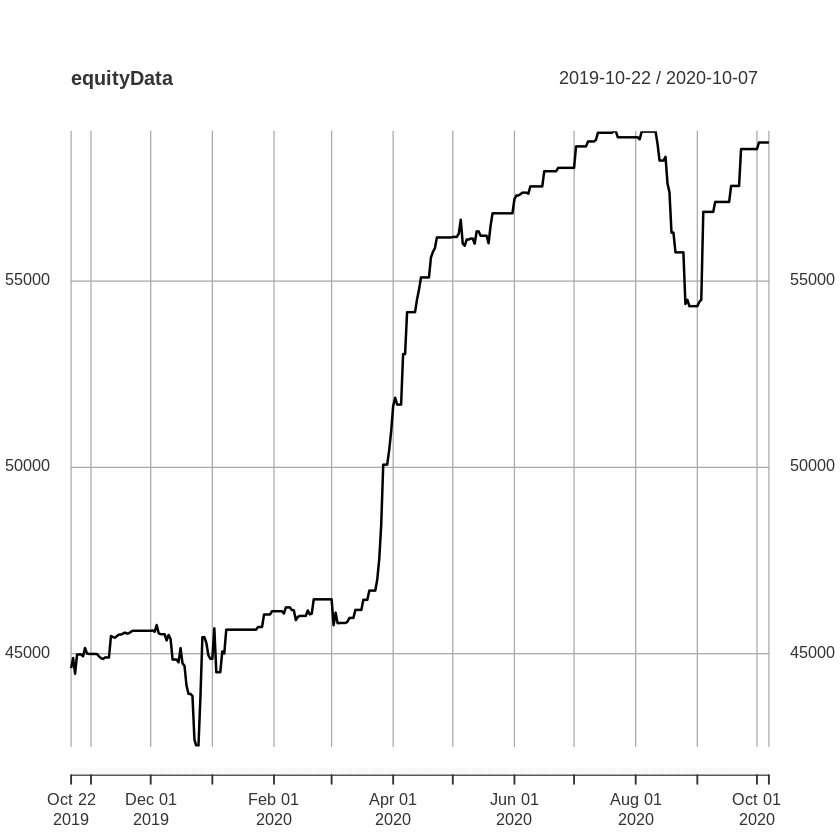

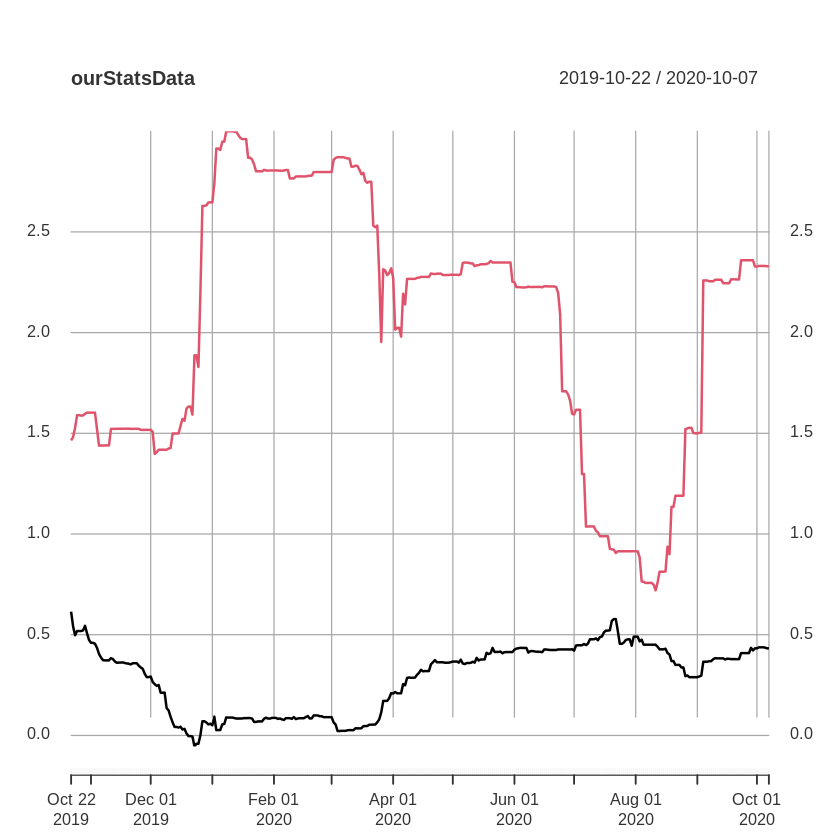

In [19]:
# Prepare data for plots and show them
equityData <- as.xts.data.table(data[,list(date, Close)])
plot(equityData)

ourStatsData <- as.xts.data.table(data[,list(date, AnnReturn210,SD090)])
plot(ourStatsData)

           AnnReturn210    SD090 CarltonIndex090
2019-10-22    0.6144353 1.464256       0.4196230
2019-10-23    0.5409259 1.481708       0.3650691
2019-10-24    0.4974198 1.526926       0.3257654
2019-10-25    0.5183678 1.589994       0.3260186
2019-10-26    0.5183678 1.589994       0.3260186
2019-10-27    0.5182121 1.587919       0.3263467

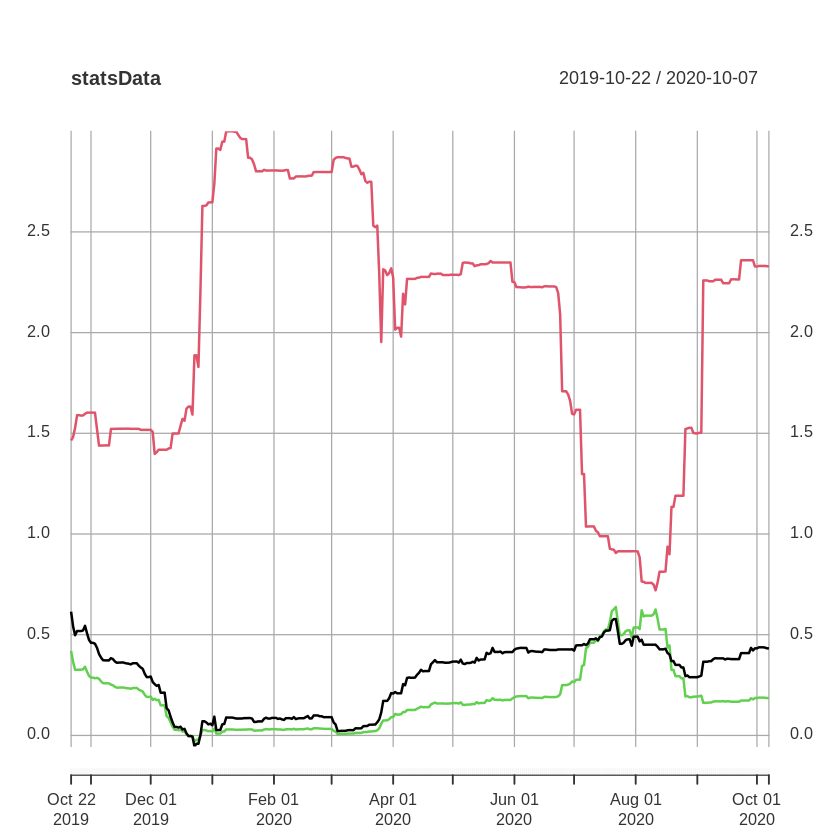

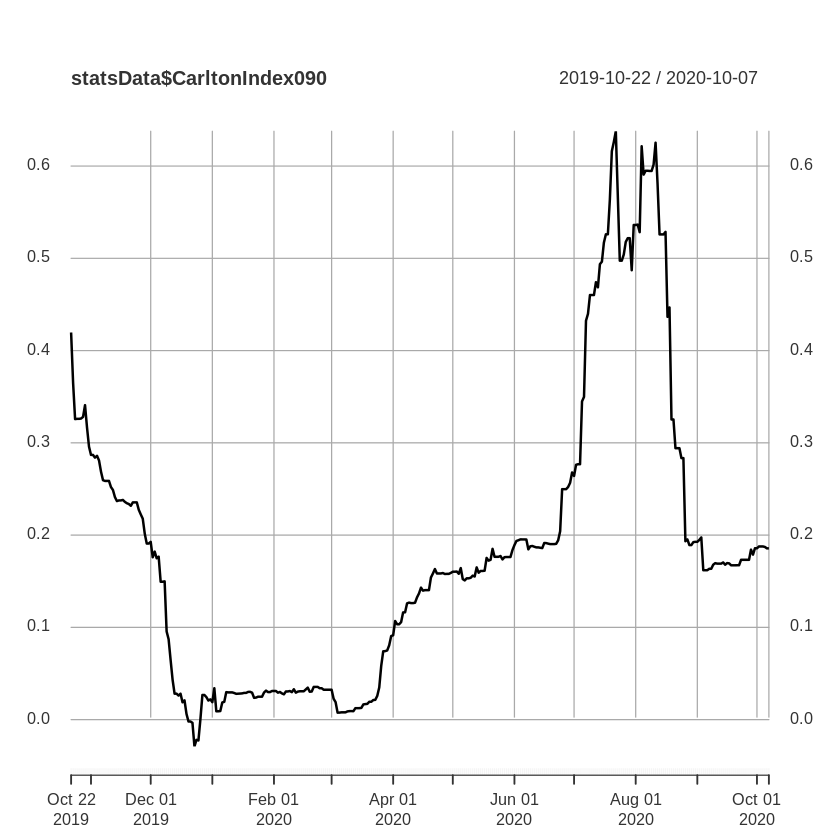

In [24]:
# Let's caculate and plot CarltonIndex now: 0.1 * AnnReturn210 / SD090
# Let's omit multiplication by 0.1 here for plotting purposes.

statsData$CarltonIndex090 <- statsData$AnnReturn210 / statsData$SD090

head(statsData)
plot(statsData)

# Plot CarltonIndex alone
plot(statsData$CarltonIndex090)